In [1]:
%load_ext pycodestyle_magic
%flake8_on

# Goals:
* Test a different validation scheme for this competition (a few month of data, drop one month, valid one month
* get validation/ public LB for each fold
* see if the results correlate (i.e: is this validation strategy correct ?)

In [7]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, \
                            precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb

import datetime
from reduce_mem_usage import reduce_mem_usage

pd.set_option('max_columns', 100)
pd.set_option('max_rows', 1000)

In [3]:
train_transaction = pd.read_csv('input/train_transaction.csv',
                                index_col='TransactionID')
test_transaction = pd.read_csv('input/test_transaction.csv',
                               index_col='TransactionID')

train_identity = pd.read_csv('input/train_identity.csv',
                             index_col='TransactionID')
test_identity = pd.read_csv('input/test_identity.csv',
                            index_col='TransactionID')

sample_submission = pd.read_csv('input/sample_submission.csv',
                                index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left',
                                left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left',
                              left_index=True, right_index=True)

print(train.shape)
print(test.shape)

(590540, 433)
(506691, 432)


In [4]:
del train_transaction, train_identity, test_transaction, test_identity

In [5]:
# Label Encoding
for f in train.columns:
    if f != 'isFraud':
        if train[f].dtype == 'object' or test[f].dtype == 'object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train[f].values) + list(test[f].values))
            train[f] = lbl.transform(list(train[f].values))
            test[f] = lbl.transform(list(test[f].values))

In [6]:
train['RANDOM_NOISE'] = np.random.normal(size=len(train))

In [7]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')


def add_seconds(x):
    return START_DATE + datetime.timedelta(seconds=x)


train['DT'] = train['TransactionDT'].apply(add_seconds)
test['DT'] = test['TransactionDT'].apply(add_seconds)

In [12]:
TARGET = 'isFraud'
# The June month drops entirely
print(train['DT'].max())
print(test['DT'].min())
# So we need to get rid of April and keep May as validation set
X_train = train[train['DT'] <= '2018-03-31'].copy()
y_train = X_train[TARGET]
X_train.drop(['isFraud', 'DT'], axis=1, inplace=True)
# We do that for valid as well
X_valid = train[(train['DT'] >= '2018-05-01')].copy()
y_valid = X_valid[TARGET]
X_valid.drop(['isFraud', 'DT'], axis=1, inplace=True)

NameError: name 'train' is not defined

# Some funcs

In [9]:
def results(m, X_train=X_train, y_train=y_train,
            X_valid=X_valid, y_valid=y_valid):
    preds_train = m.predict(X_train)
    preds_valid = m.predict(X_valid)
    res = {'train_recall': recall_score(y_train, preds_train.round()),
           'valid_recall': recall_score(y_valid, preds_valid.round()),
           'train_precision': precision_score(y_train, preds_train.round()),
           'valid_precision': precision_score(y_valid, preds_valid.round()),
           'train_f1': f1_score(y_train, preds_train.round()),
           'valid_f1': f1_score(y_valid, preds_valid.round()),
           'train_roc': roc_auc_score(y_train, preds_train),
           'valid_roc': roc_auc_score(y_valid, preds_valid)
           }
    return res

In [10]:
def get_xgb():
    return xgb.XGBClassifier(
        n_estimators=500,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.2,
        colsample_bytree=0.5,
        tree_method='gpu_hist',
        njobs=8
    )

In [11]:
lgb_params = {'objective': 'binary',
              'boosting_type': 'gbdt',
              'metric': 'auc',
              'n_jobs': 8,
              'learning_rate': 0.01,
              'num_leaves': 496,
              'max_depth': -1,
              'tree_learner': 'serial',
              'colsample_bytree': 0.7,
              'subsample_freq': 1,
              'subsample': 0.7,
              'n_estimators': 800,
              'max_bin': 255,
              'verbose': -1,
              'seed': 24,
              'early_stopping_rounds': 100
              }

# Modeling: predict 5 times the valid, then five time the test with X_train and get correlations

In [49]:
clf = get_xgb()
clf.fit(X_train, y_train)
results(clf)
# LB AUC: 0.7282

{'train_recall': 0.660958904109589,
 'valid_recall': 0.36095054592164416,
 'train_precision': 0.9845934088358331,
 'valid_precision': 0.7746381805651275,
 'train_f1': 0.7909511905249785,
 'valid_f1': 0.49244249726177436,
 'train_roc': 0.8302906746820754,
 'valid_roc': 0.6785787852328956}

In [55]:
RF = RandomForestClassifier(n_estimators= 100, n_jobs=8)
RF.fit(X_train.fillna(0), y_train)
results(RF, X_train=X_train.fillna(0), X_valid=X_valid.fillna(0))
# LB AUC: 0.7040

{'train_recall': 0.9993150684931507,
 'valid_recall': 0.315028901734104,
 'train_precision': 1.0,
 'valid_precision': 0.8134328358208955,
 'train_f1': 0.999657416923604,
 'valid_f1': 0.45416666666666666,
 'train_roc': 0.9996575342465753,
 'valid_roc': 0.6562095281184788}

In [57]:
XT = ExtraTreesClassifier(n_estimators=100, n_jobs=8)
XT.fit(X_train.fillna(0), y_train)
results(XT, X_train=X_train.fillna(0), X_valid=X_valid.fillna(0))
# LB AUC: 0.6871

{'train_recall': 1.0,
 'valid_recall': 0.2922286448298009,
 'train_precision': 1.0,
 'valid_precision': 0.8183453237410072,
 'train_f1': 1.0,
 'valid_f1': 0.43066729768102224,
 'train_roc': 1.0,
 'valid_roc': 0.6449427917695146}

In [11]:
tr_data = lgb.Dataset(X_train, label=y_train)
vl_data = lgb.Dataset(X_valid, label=y_valid) 


my_lightgbm = lgb.train(
        lgb_params,
        tr_data,
        valid_sets=[tr_data, vl_data],
        verbose_eval=100,
)

C:\Users\benjamin\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\benjamin\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.953668	valid_1's auc: 0.886664
[200]	training's auc: 0.975739	valid_1's auc: 0.897996
[300]	training's auc: 0.991531	valid_1's auc: 0.906465
[400]	training's auc: 0.997183	valid_1's auc: 0.910833
[500]	training's auc: 0.999004	valid_1's auc: 0.912575
[600]	training's auc: 0.999647	valid_1's auc: 0.91324
[700]	training's auc: 0.999884	valid_1's auc: 0.913772
[800]	training's auc: 0.999964	valid_1's auc: 0.91364
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.999964	valid_1's auc: 0.91364


In [ ]:
results(my_lightgbm)
# LB AUC 0.9193

In [12]:
LR = LogisticRegression(C=1000000)
LR.fit(X_train.fillna(0), y_train)
results(LR, X_train=X_train.fillna(0), X_valid=X_valid.fillna(0))
# LB AUC 0.5098

C:\Users\benjamin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\benjamin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


{'train_recall': 0.0017123287671232876,
 'valid_recall': 0.005780346820809248,
 'train_precision': 0.1,
 'valid_precision': 0.01348314606741573,
 'train_f1': 0.0033670033670033664,
 'valid_f1': 0.008091706001348616,
 'train_roc': 0.5005748735963975,
 'valid_roc': 0.4952520255887557}

## predict the test set

In [13]:
submission = pd.read_csv('input/sample_submission.csv')

In [14]:
X_test = test.copy()
X_test.drop('DT', axis=1, inplace=True)
X_test['RANDOM_NOISE'] = np.random.normal(size=len(X_test))

In [74]:
# XGB 0.7282
preds_xgb = clf.predict(X_test)
submission['isFraud'] = preds_xgb
submission.to_csv('submission.csv', index=False)

In [ ]:
!kaggle competitions submit -f submission.csv -m 'soumissionxgbbaseline' ieee-fraud-detection

In [83]:
#RF 0.7040
preds_rf = RF.predict(X_test.fillna(0))
submission['isFraud'] = preds_rf
submission.to_csv('submission.csv', index=False)

In [ ]:
!kaggle competitions submit -f submission.csv -m 'soumissionRFbaseline' ieee-fraud-detection

In [85]:
#XT 0.6871
preds_xt = XT.predict(X_test.fillna(0))
submission['isFraud'] = preds_xt
submission.to_csv('submission.csv', index=False)

In [ ]:
!kaggle competitions submit -f submission.csv -m 'soumissionXTbaseline' ieee-fraud-detection

In [17]:
#LGB 0.9193
preds_lgb = my_lightgbm.predict(X_test)
submission['isFraud'] = preds_lgb
submission.to_csv('submission.csv', index=False)

In [16]:
#LR 0.5098
preds_lr = LR.predict(X_test.fillna(0))
submission['isFraud'] = preds_lr
submission.to_csv('submission.csv', index=False)

## Is validation set representative of public LB ?

In [8]:
valid_aucs = np.array([0.6785, 0.6562, 0.6449,  0.9136, 0.4952])
LB_aucs = np.array([0.7282, 0.7040, 0.6871,  0.9193, 0.5098])

In [10]:
data = pd.DataFrame([valid_aucs, LB_aucs]).T
data.columns = ['valid', 'publicLB']
data

,valid,publicLB
0,0.6785,0.7282
1,0.6562,0.7040
2,0.6449,0.6871
3,0.9136,0.9193
4,0.4952,0.5098


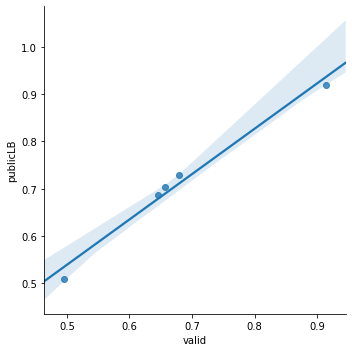

In [11]:
sns.lmplot('valid', 'publicLB', data=data)

# The higher the validation score, the higher the score on the public leaderboard
I think we can go with that validation strategy